In [111]:
!pip install --upgrade pip
!pip install pandas scikit-learn matplotlib

In [112]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.dummy import DummyClassifier

In [113]:
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
cmap = matplotlib.colormaps['tab10']
blue = cmap(0)
green = cmap(2)
yellow = cmap(8)

In [114]:
y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'10epochs_y_real.npy'))
X = np.zeros((len(y_true), 1))
results = []
classes = np.unique(y_true)
classes

array(['credit_note', 'debit_note', 'order', 'proforma', 'purchase_order',
       'receipt', 'sales_order', 'tax_invoice', 'utility_bill'],
      dtype='<U14')

In [115]:
def evaluate(classifier, y_true, y_pred):
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print(f'{classifier} balanced accuracy: {balanced_accuracy:.4f}')
    result = {
        'classifier': classifier,
        'balanced_accuracy': balanced_accuracy
    }
    results.append(result)

## Class Distribution

In [116]:
counts = pd.Series(y_true).value_counts(ascending=True)
counts

debit_note           2
utility_bill         4
proforma             6
credit_note          7
receipt            224
sales_order        424
purchase_order     634
order             1121
tax_invoice       1457
Name: count, dtype: int64

In [117]:
classes_ger = ['Lastschrift', 'Strom- und\nGasrechnung', 'Proforma', 'Gutschrift', 'Beleg', 'Kunden-\nauftrag', 'Auftrags-\nbestätigung', 'Auftrag', 'Steuer-\nrechnung']
counts.index = classes_ger
counts

Lastschrift                   2
Strom- und\nGasrechnung       4
Proforma                      6
Gutschrift                    7
Beleg                       224
Kunden-\nauftrag            424
Auftrags-\nbestätigung      634
Auftrag                    1121
Steuer-\nrechnung          1457
Name: count, dtype: int64

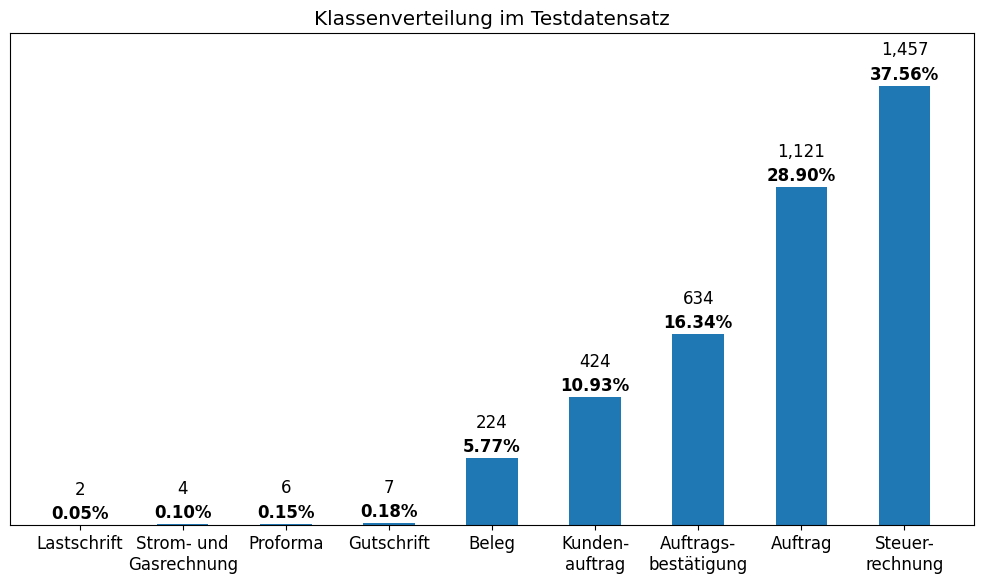

In [118]:
plt.figure(figsize=(10, 6))
plt.bar(x=counts.index, height=counts.values, width=0.5)

# Displaying percentages above each bar
for i, count in enumerate(counts.values):
    perc = count / len(y_true) * 100
    plt.text(i, count + 100, f'{count:,}', ha='center', fontsize=fontsize, weight='normal')  # First row normal
    plt.text(i, count + 20, f'{perc:.2f}%', ha='center', fontsize=fontsize, weight='bold')  # Second row bold

plt.title('Klassenverteilung im Testdatensatz')
plt.ylim(0, 1630)
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join('Plots', 'class_distribution_test_set.png'), bbox_inches='tight')

plt.show()

## Baseline

### Dummy Classifier

In [119]:
strategies = ['most_frequent', 'stratified']
classifiers = ['Baseline\nMost\nFrequent Class', 'Baseline\nWeighted\nGuessing']

for strategy, classifier in zip(strategies, classifiers):
    clf = DummyClassifier(strategy=strategy, random_state=0)
    clf.fit(X=None, y=y_true)
    y_pred = clf.predict(y_true)
    evaluate(classifier, y_true, y_pred)

Baseline
Most
Frequent Class balanced accuracy: 0.1111
Baseline
Weighted
Guessing balanced accuracy: 0.1035


### Zero Rate and Random Rate

In [120]:
def zero_rate(class_frequencies):
    return max(class_frequencies)

def random_rate(class_frequencies):
    return sum([class_frequency ** 2 for class_frequency in class_frequencies])

In [121]:
class_frequencies = pd.Series(y_true).value_counts(normalize=True).values
print(f'zero rate: {zero_rate(class_frequencies):.4f}')
print(f'random rate: {random_rate(class_frequencies):.4f}')

zero rate: 0.3756
random rate: 0.2666


## Donut Classification

In [122]:
# Load the predictions of the best donut model
donut_y_pred = np.load(os.path.join('Arrays', 'DonutClassification', f'10epochs_y_pred.npy')).tolist()
evaluate('Donut', y_true, donut_y_pred)

Donut balanced accuracy: 0.7918


In [123]:
pd.DataFrame(results)

,classifier,balanced_accuracy
0,Baseline\nMost\nFrequent Class,0.111111
1,Baseline\nWeighted\nGuessing,0.103505
2,Donut,0.791832


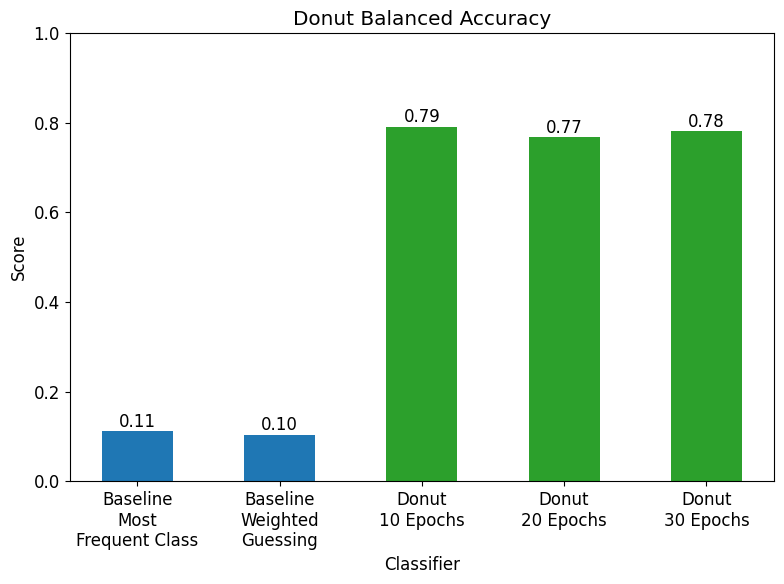

In [124]:
epoch_counts = ['10', '20', '30']
results_donut = []

for epochs in epoch_counts:
    y_pred = np.load(os.path.join('Arrays', 'DonutClassification', f'{epochs}epochs_y_pred.npy'))
    result = {
        'classifier': f'Donut\n{epochs} Epochs',
        'balanced_accuracy': metrics.balanced_accuracy_score(y_true, y_pred)
    }
    results_donut.append(result)
    
results_donut.insert(0, results[0])
results_donut.insert(1, results[1])
results_donut_df = pd.DataFrame(results_donut)

colors = [blue, blue, green, green, green]
plt.figure(figsize=(8, 6))
plt.bar(x=results_donut_df['classifier'], height=results_donut_df['balanced_accuracy'], width=0.5, color=colors)
plt.title('Donut Balanced Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.ylim(0, 1)

# Displaying percentages above each bar
for i, score in enumerate(results_donut_df['balanced_accuracy']):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')

plt.tight_layout()
plt.savefig(os.path.join('Plots', 'donut_balanced_accuracy.png'), bbox_inches='tight')
plt.show()

## VGG16 Classification

In [125]:
def evaluate_cnn(cnn):
    layers_versions = ['added_layer', 'all_layer']
    layers_versions_pretty = ['Added Layers', 'All Layers']
    epoch_counts = ['30', '50', '100']
    y_true = np.load(os.path.join('Arrays', cnn, f'y_test.npy'))
    y_true = [classes[np.argmax(sample)] for sample in vgg16_y_true]
    results_cnn = []
    
    for layers, layers_pretty in zip(layers_versions, layers_versions_pretty):
        for epochs in epoch_counts:
            y_pred = np.load(os.path.join('Arrays', cnn, f'predictions_{layers}_{epochs}epochs_10_5.npy'))
            balanced_accuracy = metrics.balanced_accuracy_score(inceptionv3_y_true, y_pred)
            result = {
                'classifier': f'{cnn}\n{layers_pretty}\n{epochs} Epochs',
                'balanced_accuracy': balanced_accuracy
            }
            results_cnn.append(result)
    
    results_cnn.insert(0, results[0])
    results_cnn.insert(1, results[1])
    results_cnn_df = pd.DataFrame(results_cnn)
    
    colors = [blue, blue, green, green, green, yellow, yellow, yellow]
    plt.figure(figsize=(11, 6))
    plt.bar(x=results_cnn_df['classifier'], height=results_cnn_df['balanced_accuracy'], width=0.5, color=colors)
    
    plt.title(f'{cnn} Balanced Accuracy')
    
    plt.xlabel('Classifier')
    
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Displaying percentages above each bar
    for i, score in enumerate(results_cnn_df['balanced_accuracy']):
        plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')
    
    plt.tight_layout()
    plt.savefig(os.path.join('Plots', f'{cnn.lower()}_balanced_accuracy.png'), bbox_inches='tight')
    plt.show()

In [126]:
# Load the predictions of the best VGG16 model
vgg16_y_true = np.load(os.path.join('Arrays', 'VGG16', f'y_test.npy'))
vgg16_y_true = [classes[np.argmax(sample)] for sample in vgg16_y_true]
vgg16_y_pred = np.load(os.path.join('Arrays', 'VGG16', f'predictions_all_layer_50epochs_10_5.npy'))
evaluate('VGG16', vgg16_y_true, vgg16_y_pred)

VGG16 balanced accuracy: 0.9376


In [127]:
pd.DataFrame(results)

,classifier,balanced_accuracy
0,Baseline\nMost\nFrequent Class,0.111111
1,Baseline\nWeighted\nGuessing,0.103505
2,Donut,0.791832
3,VGG16,0.937553


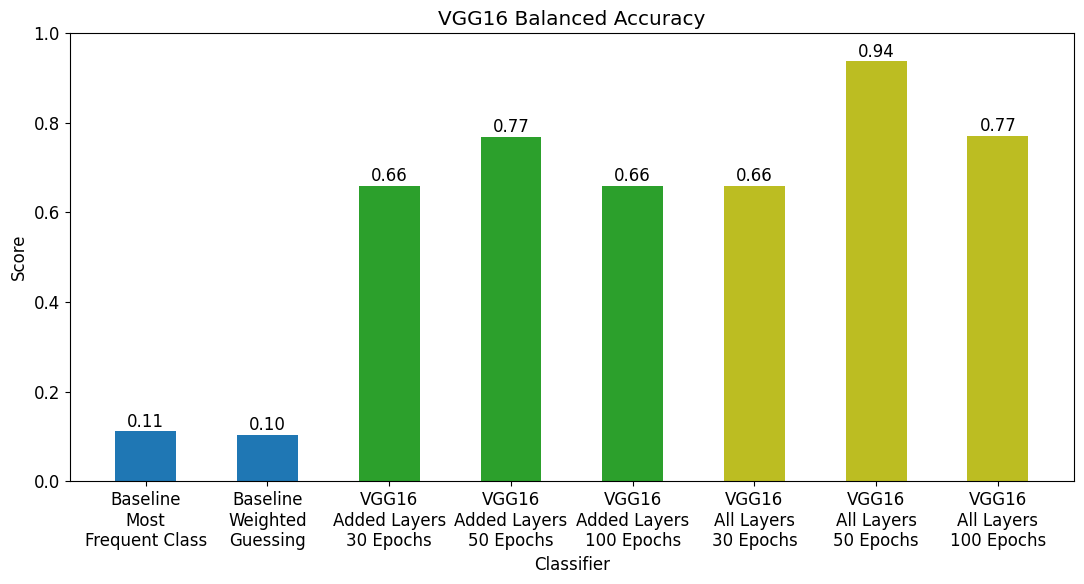

In [128]:
evaluate_cnn('VGG16')

## InceptionV3 Classification

In [129]:
# Load the predictions of the best InceptionV3 model
inceptionv3_y_true = np.load(os.path.join('Arrays', 'InceptionV3', f'y_test.npy'))
inceptionv3_y_true = [classes[np.argmax(sample)] for sample in inceptionv3_y_true]
inceptionv3_y_pred = np.load(os.path.join('Arrays', 'InceptionV3', f'predictions_all_layer_100epochs_10_5.npy'))
evaluate('InceptionV3', inceptionv3_y_true, inceptionv3_y_pred)

InceptionV3 balanced accuracy: 0.8850


In [130]:
pd.DataFrame(results)

,classifier,balanced_accuracy
0,Baseline\nMost\nFrequent Class,0.111111
1,Baseline\nWeighted\nGuessing,0.103505
2,Donut,0.791832
3,VGG16,0.937553
4,InceptionV3,0.885043


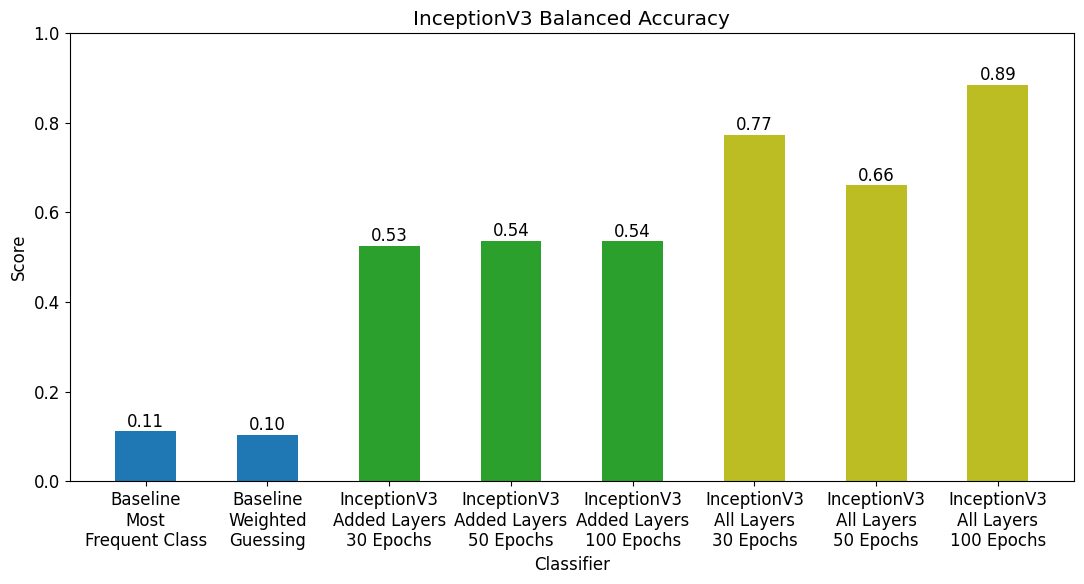

In [131]:
evaluate_cnn('InceptionV3')

## LayoutLMv3 Classification

In [132]:
# Load the predictions of the best LayoutLMv3 model
layoutlmv3_y_true = np.load(os.path.join('Arrays', 'LayoutLMv3', f'test_images.npy'), allow_pickle=True)

## Bar Chart

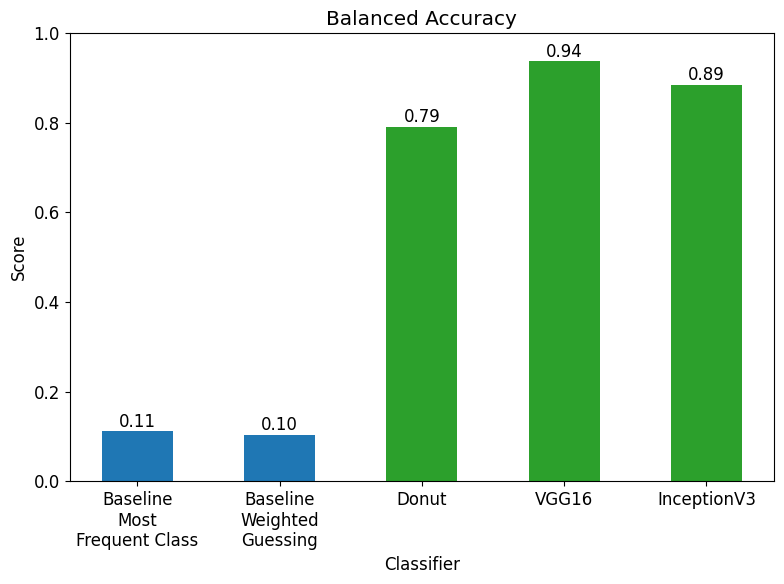

In [133]:
results_df = pd.DataFrame(results)

colors = [blue, blue, green, green, green]
plt.figure(figsize=(8, 6))
plt.bar(x=results_df['classifier'], height=results_df['balanced_accuracy'], width=0.5, color=colors)
plt.title('Balanced Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.ylim(0, 1)

# Displaying percentages above each bar
for i, score in enumerate(results_df['balanced_accuracy']):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', fontsize=fontsize, weight='normal')

plt.tight_layout()
plt.savefig(os.path.join('Plots', 'balanced_accuracy.png'), bbox_inches='tight')
plt.show()